In [1]:
from dataloader import DataLoader, DataTransformer
from model import Model
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
import pyfolio as pf
%matplotlib inline

Using TensorFlow backend.


In [2]:
tickers = ['SPY']
from_date = datetime(2001, 1, 1)
to_date = datetime(2017, 1, 1)
entry_percentage = 0.65

In [3]:
loader = DataLoader(tickers, from_date=from_date, to_date=to_date)
loader.reload_all()

In [4]:
transformer = DataTransformer(loader)
transformer.transform()

In [5]:
model = Model(transformer)
model.build_model_data()
model.build_neural_net()

In [6]:
datetime(2016, 12, 31).strftime('%Y-%m-%d')

'2016-12-31'

In [7]:
model.predict_one('SPY', '2016-10-18')[0]

array([ 0.59352255,  0.40647745], dtype=float32)

In [8]:
def entries_to_remove(entries, the_dict):
    for key in entries:
        if key in the_dict:
            del the_dict[key]

In [12]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.orders = {}
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def next(self):
        if not self.position:
            try:
                today = self.datas[0].datetime.date(0).isoformat()
                prediction = model.predict_one('SPY', today)[0]
                if prediction[0] > entry_percentage:
                    self.log('predicted long')
                    self.orders[len(self)] = self.buy()
                elif prediction[1] > entry_percentage:
                    self.log('predicted short')
                    self.orders[len(self)] = self.sell()
            except Exception as e:
                self.log(e)
        
        old_entries = []
        for days, order_on_days in self.orders.items():
            if len(self) >= days + 5:
                old_entries.append(days)
                if order_on_days.isbuy():
                    self.log('closing the long position')
                    self.sell()
                else:
                    self.log('closing the short position')
                    self.buy()
        entries_to_remove(old_entries, self.orders)

In [13]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname='SPY',
    fromdate=from_date,
    todate=to_date,
    reverse=False)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.PercentSizer, percents=3)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2001-01-02, 'the label [2001-01-02] is not in the [index]'
2001-01-03, 'the label [2001-01-03] is not in the [index]'
2001-01-04, 'the label [2001-01-04] is not in the [index]'
2001-01-05, 'the label [2001-01-05] is not in the [index]'
2001-01-08, 'the label [2001-01-08] is not in the [index]'
2001-01-09, 'the label [2001-01-09] is not in the [index]'
2001-01-10, 'the label [2001-01-10] is not in the [index]'
2001-01-11, 'the label [2001-01-11] is not in the [index]'
2001-01-12, 'the label [2001-01-12] is not in the [index]'
2001-01-16, 'the label [2001-01-16] is not in the [index]'
2001-01-17, 'the label [2001-01-17] is not in the [index]'
2001-01-18, 'the label [2001-01-18] is not in the [index]'
2001-01-19, 'the label [2001-01-19] is not in the [index]'
2001-01-22, 'the label [2001-01-22] is not in the [index]'
2001-01-23, 'the label [2001-01-23] is not in the [index]'
2001-01-24, 'the label [2001-01-24] is not in the [index]'
2001-01-25, 'the lab

2004-08-11, predicted long
2004-08-12, BUY EXECUTED, 107.68
2004-08-18, closing the long position
2004-08-19, SELL EXECUTED, 109.81
2004-09-03, predicted long
2004-09-07, BUY EXECUTED, 112.54
2004-09-13, closing the long position
2004-09-14, SELL EXECUTED, 113.30
2004-09-20, predicted long
2004-09-21, BUY EXECUTED, 112.75
2004-09-27, closing the long position
2004-09-28, SELL EXECUTED, 110.91
2004-12-21, predicted long
2004-12-22, BUY EXECUTED, 120.38
2004-12-29, closing the long position
2004-12-30, SELL EXECUTED, 121.40
2005-01-05, predicted long
2005-01-06, BUY EXECUTED, 118.44
2005-01-12, closing the long position
2005-01-13, SELL EXECUTED, 118.64
2005-02-18, predicted long
2005-02-22, BUY EXECUTED, 119.90
2005-02-28, closing the long position
2005-03-01, SELL EXECUTED, 120.82
2005-04-27, predicted long
2005-04-28, BUY EXECUTED, 115.27
2005-05-04, closing the long position
2005-05-05, SELL EXECUTED, 117.67
2005-05-12, predicted long
2005-05-13, BUY EXECUTED, 116.30
2005-05-19, clos

2010-07-14, predicted short
2010-07-15, SELL EXECUTED, 109.61
2010-07-21, closing the short position
2010-07-22, BUY EXECUTED, 108.34
2010-07-28, predicted long
2010-07-29, BUY EXECUTED, 111.52
2010-08-04, closing the long position
2010-08-05, SELL EXECUTED, 112.25
2010-08-13, predicted long
2010-08-16, BUY EXECUTED, 107.57
2010-08-20, closing the long position
2010-08-23, SELL EXECUTED, 108.04
2010-08-25, predicted long
2010-08-26, BUY EXECUTED, 106.44
2010-09-01, closing the long position
2010-09-02, SELL EXECUTED, 108.72
2010-09-08, predicted long
2010-09-09, BUY EXECUTED, 111.65
2010-09-15, closing the long position
2010-09-16, SELL EXECUTED, 112.73
2010-10-04, predicted long
2010-10-05, BUY EXECUTED, 114.80
2010-10-11, closing the long position
2010-10-12, SELL EXECUTED, 116.27
2010-10-19, predicted long
2010-10-20, BUY EXECUTED, 116.94
2010-10-26, closing the long position
2010-10-27, SELL EXECUTED, 117.89
2010-12-27, predicted long
2010-12-28, BUY EXECUTED, 125.90
2011-01-03, cl

2014-09-10, predicted long
2014-09-11, BUY EXECUTED, 199.27
2014-09-17, closing the long position
2014-09-18, SELL EXECUTED, 201.36
2014-10-10, predicted long
2014-10-13, BUY EXECUTED, 190.46
2014-10-17, closing the long position
2014-10-20, SELL EXECUTED, 188.13
2014-10-20, predicted long
2014-10-21, BUY EXECUTED, 191.68
2014-10-27, closing the long position
2014-10-28, SELL EXECUTED, 196.82
2014-10-29, predicted long
2014-10-30, BUY EXECUTED, 197.58
2014-11-05, closing the long position
2014-11-06, SELL EXECUTED, 202.39
2014-12-12, predicted long
2014-12-15, BUY EXECUTED, 201.98
2014-12-19, closing the long position
2014-12-22, SELL EXECUTED, 206.75
2015-02-12, predicted long
2015-02-13, BUY EXECUTED, 209.07
2015-02-20, closing the long position
2015-02-23, SELL EXECUTED, 210.94
2015-03-10, predicted long
2015-03-11, BUY EXECUTED, 205.29
2015-03-17, closing the long position
2015-03-18, SELL EXECUTED, 207.39
2015-03-26, predicted long
2015-03-27, BUY EXECUTED, 205.13
2015-04-02, clos

Start date,2001-12-18
End date,2016-12-30
Total months,180
,Backtest
Annual return,0.9%
Cumulative returns,13.9%
Annual volatility,3.3%
Sharpe ratio,0.28
Calmar ratio,0.42
Stability,0.94
Max drawdown,-2.1%


c:\programdata\anaconda3\envs\trading3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.07,2002-11-11,2002-11-19,2005-05-20,660
1,2.02,2002-07-12,2002-07-25,2002-11-06,84
2,1.63,2008-10-03,2008-10-10,2008-10-17,11
3,1.39,2008-11-17,2008-11-20,2008-12-09,17
4,1.36,2008-03-04,2008-03-10,2008-04-08,26


c:\programdata\anaconda3\envs\trading3\lib\site-packages\pyfolio\plotting.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()


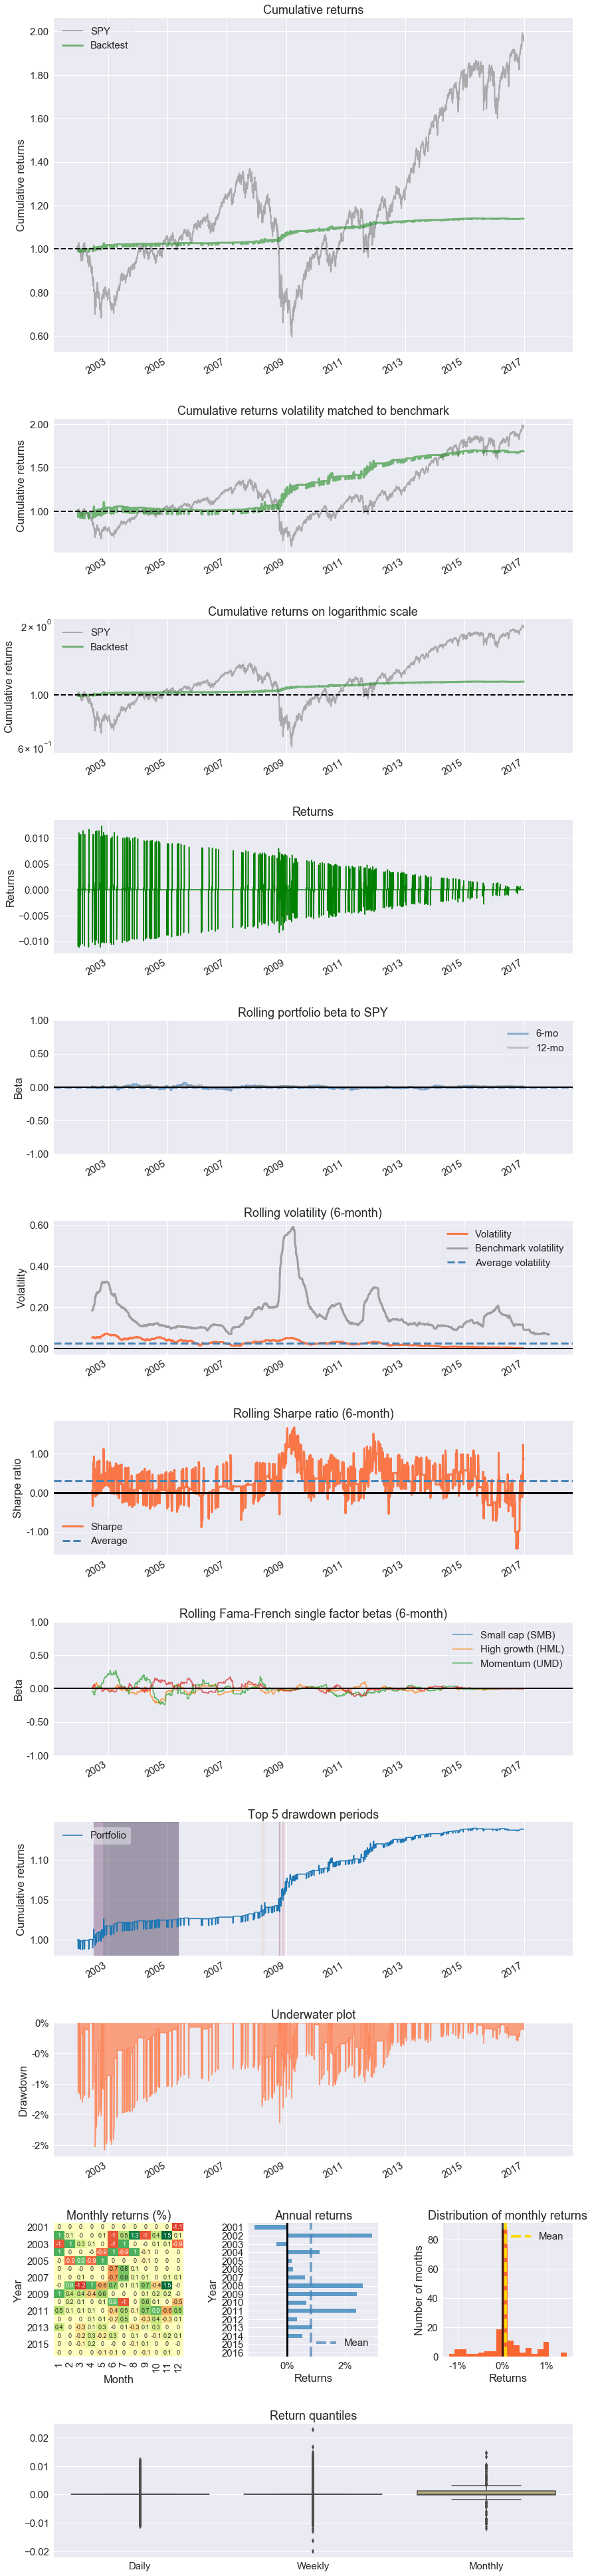

Stress Events,mean,min,max
Lehmann,0.02%,-0.67%,0.80%
9/11,-0.04%,-1.09%,1.16%
US downgrade/European Debt Crisis,0.04%,-0.48%,0.43%
Fukushima,-0.01%,-0.46%,0.46%
US Housing,-0.00%,-1.02%,1.00%
EZB IR Event,0.00%,-0.31%,0.34%
Aug07,0.00%,-0.75%,0.75%
Mar08,-0.05%,-0.68%,0.71%
Sept08,0.03%,-0.62%,0.80%
2009Q1,0.03%,-0.58%,0.66%


KeyError: '9/11'

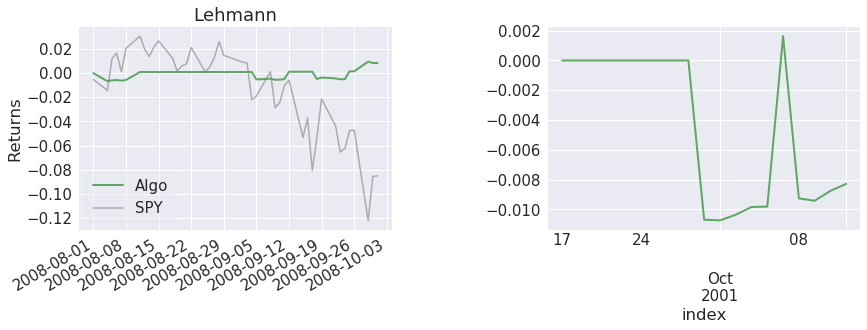

In [14]:
pf.create_full_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions, 
                          round_trips=True)